In [21]:
bill_occurance

,subjects_top_term,bill_occurance
0,Health,2685
1,Taxation,2518
2,Armed forces and national security,2137
3,Government operations and politics,1799
4,Public lands and natural resources,1423
5,Crime and law enforcement,1400
6,Education,1098
7,Finance and financial sector,1073
8,Transportation and public works,1022
9,International affairs,926


In [25]:
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

### Training dataset.

In [288]:
def split_data(X, y):
    (X_train,
     X_test,
     y_train,
     y_test) = sklearn.model_selection.train_test_split(X, y, test_size=0.25, random_state=33)
    return X_train, X_test, y_train, y_test


def basic_classifier_train(classifier,
                           X_train, X_test, y_train, y_test):

    classifier.fit(X_train, y_train.values.ravel())
    print("Accuracy: {} ".format(classifier.score(X_test, y_test.values.ravel())))
    return classifier

In [43]:
tfiles = [f for f in TRAINING_FILES if 'trainingdata_v2_GLOVEemb100_Health20190211' in f]

In [44]:
df_tr = pd.DataFrame()
for file_name in tfiles:
    training_data = pd.read_csv(PATH_TO_TRAINING + file_name)
    del training_data['Unnamed: 0']
    #df_tr = pd.DataFrame()
    df_tr = df_tr.append(training_data)

In [46]:
efiles = [f for f in TRAINING_FILES if 'allembeddings_v2_GLOVEemb100_Health20190211' in f]

In [48]:
df_em = pd.DataFrame()
for file_name in efiles:
    training_data = pd.read_csv(PATH_TO_TRAINING + file_name)
    del training_data['Unnamed: 0']
    df_em = df_em.append(training_data)

In [49]:
df_tr.shape

(156897, 103)

In [50]:
df_em.shape

(169059, 103)

In [51]:
df_em.groupby('in_summary').size()

in_summary
0    118109
1     38788
2     12162
dtype: int64

In [292]:
tr = df_tr.copy()

In [293]:
del tr['loc_ix']
del tr['bill_id']

In [294]:
tr = tr.reset_index(drop=True)

In [52]:
target_names = ['not_summary', 'in_summary']
class_names = target_names

In [295]:
y = tr[['in_summary']]
X = tr.drop(columns=['in_summary'])

In [296]:
X_train, X_test, y_train, y_test = split_data(X, y)

### Logistic Regression.

In [404]:
try_lr = LogisticRegression(C=1e5, solver='lbfgs', max_iter=1000)

/Users/melissaferrari/anaconda3/envs/congress_py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Accuracy: 0.8093443607016608 
Normalized confusion matrix
[[0.93 0.07]
 [0.56 0.44]]


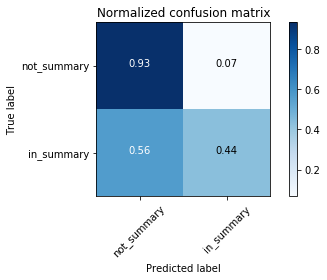

In [406]:
#all_feat = sparse.hstack([X_match.drop(columns=['bill_id']), tfidf_mat,  ])
#feat_array = all_feat.toarray()
feat_array = np.hstack([X_match.drop(columns=['bill_id']), df_match_])
feat_array_ = np.nan_to_num(feat_array)

X_train, X_test, y_train, y_test = split_data(feat_array_, y_training)

genera_model = basic_classifier_train(try_lr, X_train, X_test, y_train, y_test)

y_pred = genera_model.predict(X_test)
y_pred_train = genera_model.predict(X_train)

plot_confusion_matrix(confusion_matrix(y_test, y_pred), 
                      classes=class_names, normalize=True, title='Normalized confusion matrix');

In [379]:
y_pred = mdl_lgreg.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

In [59]:
report = calculate_metrics(mdl_lgreg, X_test, y_test)

In [57]:
X = training_data.drop(columns=['in_summary'])
y = training_data[['in_summary']]

### Stochastic Gradient descent.

In [381]:
from sklearn.linear_model import SGDClassifier
#X_train, X_test, y_train, y_test = split_data(X, y)
trial6 = sklearn.pipeline.Pipeline([('SGD', sklearn.linear_model.SGDClassifier(max_iter=1000, tol=1e3)), ])
mdl_sgd = basic_classifier_train(trial6, X_train, X_test, y_train, y_test)
mdl_sgd

Accuracy: 0.7558193823784433 


Pipeline(memory=None,
     steps=[('SGD', SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=1000.0,
       validation_fraction=0.1, verbose=0, warm_start=False))])

Normalized confusion matrix
[[0.97 0.03]
 [0.91 0.09]]


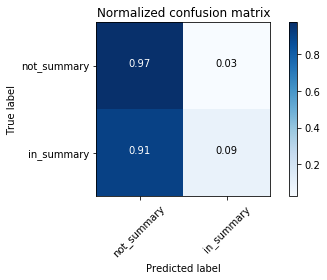

In [382]:
y_pred = mdl_sgd.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
report = calculate_metrics(mdl_sgd, X_test, y_test)

### Naive Bayes

In [306]:
trial_nb = sklearn.pipeline.Pipeline([('classifier', sklearn.naive_bayes.GaussianNB()), ])
 
mdl_nb = basic_classifier_train(trial_nb, X_train, X_test, y_train, y_test)
mdl_nb

Accuracy: 0.7065391969407265 


Pipeline(memory=None,
     steps=[('classifier', GaussianNB(priors=None, var_smoothing=1e-09))])

In [76]:
y_pred = mdl_nb.predict(X_test)
report = calculate_metrics(mdl_nb, X_test, y_test)

In [301]:
y_train_pred = mdl_nb.predict(X_train)
report = calculate_metrics(mdl_nb, X_train, y_train)

y_pred = mdl_nb.predict(X_test)
report = calculate_metrics(mdl_nb, X_test, y_test)

Normalized confusion matrix
[[0.64 0.36]
 [0.08 0.92]]


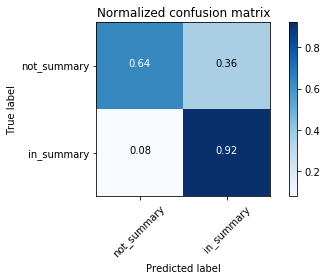

In [302]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_train, y_train_pred)
np.set_printoptions(precision=2)
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Confusion matrix, without normalization
[[56334 32129]
 [ 2296 26913]]


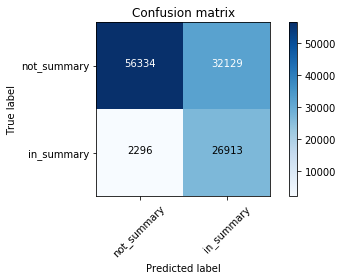

In [303]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names)

plt.show()

In [79]:
report

,f1-score,precision,recall,support
0,0.765197,0.960655,0.635829,29607.0
1,0.604985,0.450711,0.919838,9618.0
micro avg,0.705468,0.705468,0.705468,39225.0
macro avg,0.685091,0.705683,0.777834,39225.0
weighted avg,0.725913,0.835616,0.705468,39225.0


In [369]:
df_match_  = df_match.drop(columns=['bill_id', 'in_summary', 'loc_ix'])

Accuracy: 0.7705929433735743 
Normalized confusion matrix
[[0.98 0.02]
 [0.87 0.13]]


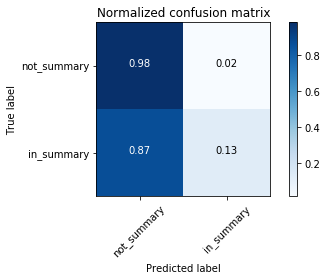

In [402]:
all_feat = sparse.hstack([X_match.drop(columns=['bill_id']), tfidf_mat,  ])
feat_array = all_feat.toarray()
#feat_array = np.hstack([X_match.drop(columns=['bill_id']), df_match_])
feat_array_ = np.nan_to_num(feat_array)

X_train, X_test, y_train, y_test = split_data(feat_array_, y_training)

mdl_nb_feats = basic_classifier_train(trial_nb, X_train, X_test, y_train, y_test)
genera_model = mdl_nb_feats

y_pred = genera_model.predict(X_test)
y_pred_train = genera_model.predict(X_train)

plot_confusion_matrix(confusion_matrix(y_test, y_pred), 
                      classes=class_names, normalize=True, title='Normalized confusion matrix');

Accuracy: 0.7699259654505436 
Normalized confusion matrix
[[0.96 0.04]
 [0.8  0.2 ]]


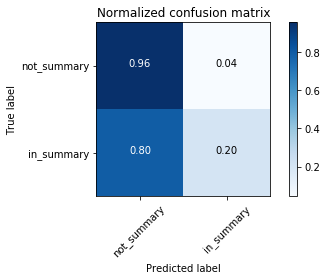

In [400]:
#all_feat = sparse.hstack([tfidf_mat, X_match.drop(columns=['bill_id']), ])
#feat_array = all_feat.toarray()
feat_array = np.hstack([X_match.drop(columns=['bill_id'])]) # , df_match_])
feat_array_ = np.nan_to_num(feat_array)

X_train, X_test, y_train, y_test = split_data(feat_array_, y_training)

mdl_nb_feats = basic_classifier_train(trial_nb, X_train, X_test, y_train, y_test)
genera_model = mdl_nb_feats

y_pred = genera_model.predict(X_test)
y_pred_train = genera_model.predict(X_train)

plot_confusion_matrix(confusion_matrix(y_test, y_pred), 
                      classes=class_names, normalize=True, title='Normalized confusion matrix');

In [394]:
y_pred = mdl_nb_feats.predict(X_test)
y_pred_train = mdl_nb_feats.predict(X_train)

### Random Forest.

In [87]:
classifiers = [RandomForestClassifier(n_estimators=1000, random_state=0), 
               SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=100, tol=1e-3), 
              LogisticRegression(C=1e5, solver='lbfgs', max_iter=100000)]

In [88]:
classifier = classifiers[2]
classifier

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [423]:
cls_rf = RandomForestClassifier(n_estimators=100, random_state=0)

In [397]:
mdl_rf = basic_classifier_train(cls_rf, X_train, X_test, y_train, y_test)

Accuracy: 0.8731741479357034 


Normalized confusion matrix
[[1.   0.  ]
 [0.04 0.96]]


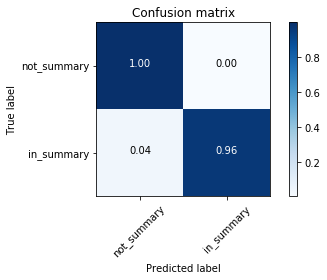

In [455]:
plot_confusion_matrix(confusion_matrix(y_train, y_pred_train), 
                      classes=class_names, normalize=True);

### Forest randomized search.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 2)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 2)]
max_depth.append(None)

# Method of selecting samples for training each tree
bootstrap = [True] #, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf =  RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)#X_train, X_test, y_train, y_test)


In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestClassifier(n_estimators = 10)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test,y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [5]:
import pickle

In [422]:
file_name = 'over_RandomForestClassifier_on_health_nestimators100_random_state0.pkl'
with open(model_save_path+file_name, 'wb') as picklefile:
    pickle.dump(genera_model, picklefile)

In [6]:
genera_model

NameError: name 'genera_model' is not defined

In [419]:
len(X_)

150043

In [420]:
X_train.shape

(119940, 7)

In [421]:
X_test.shape

(29986, 7)

In [ ]:
cls_rf = RandomForestClassifier(n_estimators=100, random_state=0)
all_feat = sparse.hstack([X_match.drop(columns=['bill_id']), tfidf_mat,  ])
feat_array = all_feat.toarray()
#feat_array = np.hstack([X_match.drop(columns=['bill_id'])])#, df_match_])
feat_array_ = np.nan_to_num(feat_array)

X_train, X_test, y_train, y_test = split_data(feat_array_, y_training)

genera_model = basic_classifier_train(cls_rf, X_train, X_test, y_train, y_test)

y_pred = genera_model.predict(X_test)
y_pred_train = genera_model.predict(X_train)

plot_confusion_matrix(confusion_matrix(y_test, y_pred), 
                      classes=class_names, normalize=True, title='Normalized confusion matrix');

Accuracy: 0.888414593476956 
Normalized confusion matrix
[[0.95 0.05]
 [0.31 0.69]]


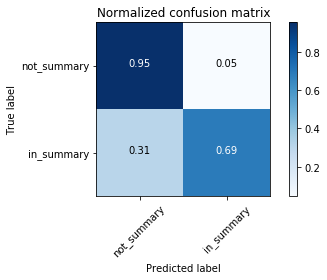

In [458]:
cls_rf = RandomForestClassifier(n_estimators=100, random_state=0)
all_feat = sparse.hstack([X_match.drop(columns=['bill_id']), tfidf_mat,  ])
feat_array = all_feat.toarray()
#feat_array = np.hstack([X_match.drop(columns=['bill_id'])])#, df_match_])
feat_array_ = np.nan_to_num(feat_array)

X_train, X_test, y_train, y_test = split_data(feat_array_, y_training)

genera_model = basic_classifier_train(cls_rf, X_train, X_test, y_train, y_test)

y_pred = genera_model.predict(X_test)
y_pred_train = genera_model.predict(X_train)

plot_confusion_matrix(confusion_matrix(y_test, y_pred), 
                      classes=class_names, normalize=True, title='Normalized confusion matrix');

In [457]:
y_Test

NameError: name 'y_Test' is not defined

Accuracy: 0.8733742413126125 
Normalized confusion matrix
[[0.94 0.06]
 [0.33 0.67]]


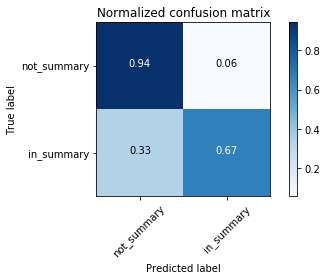

In [408]:
all_feat = sparse.hstack([X_match.drop(columns=['bill_id']), tfidf_mat,  ])
feat_array = all_feat.toarray()
#feat_array = np.hstack([X_match.drop(columns=['bill_id'])])#, df_match_])
feat_array_ = np.nan_to_num(feat_array)

X_train, X_test, y_train, y_test = split_data(feat_array_, y_training)

genera_model = basic_classifier_train(cls_rf, X_train, X_test, y_train, y_test)

y_pred = genera_model.predict(X_test)
y_pred_train = genera_model.predict(X_train)

plot_confusion_matrix(confusion_matrix(y_test, y_pred), 
                      classes=class_names, normalize=True, title='Normalized confusion matrix');

Confusion matrix, without normalization
[[21252  1337]
 [ 2460  4937]]


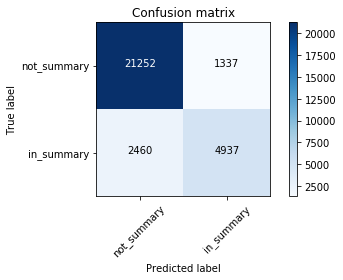

In [414]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), 
                      classes=class_names);

Confusion matrix, without normalization
[[90310   156]
 [  275 29199]]


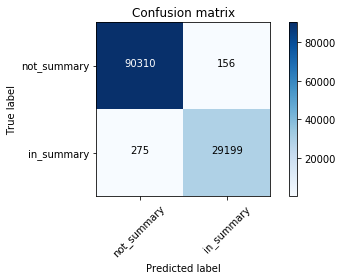

In [413]:
plot_confusion_matrix(confusion_matrix(y_train, y_pred_train), 
                      classes=class_names);

Normalized confusion matrix
[[1.   0.  ]
 [0.01 0.99]]


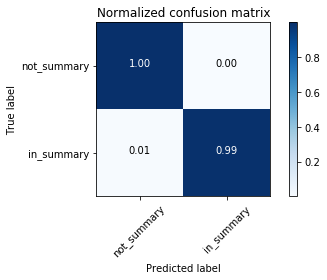

In [411]:
plot_confusion_matrix(confusion_matrix(y_train, y_pred_train), 
                      classes=class_names, normalize=True, title='Normalized confusion matrix');

Normalized confusion matrix
[[0.94 0.06]
 [0.34 0.66]]


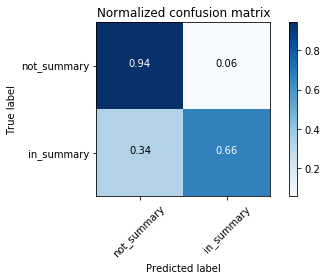

In [399]:
y_pred = mdl_rf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [385]:
report = calculate_metrics(mdl_rf, X_test, y_test , as_csv=True, save=False)
report

,f1-score,precision,recall,support
0,0.933513,0.916088,0.951614,22589.0
1,0.779997,0.832388,0.733811,7397.0
micro avg,0.897886,0.897886,0.897886,29986.0
macro avg,0.856755,0.874238,0.842712,29986.0
weighted avg,0.895643,0.895440,0.897886,29986.0


In [386]:
y_pred = mdl_rf.predict(X_test)
report = calculate_metrics(mdl_rf, X_test, y_test)
report

,f1-score,precision,recall,support
0,0.933513,0.916088,0.951614,22589.0
1,0.779997,0.832388,0.733811,7397.0
micro avg,0.897886,0.897886,0.897886,29986.0
macro avg,0.856755,0.874238,0.842712,29986.0
weighted avg,0.895643,0.895440,0.897886,29986.0


In [571]:
y_.shape

(150043, 2)

In [570]:

X_train, X_test, y_train, y_test = split_data(feat_array_, y_training)


(150043, 8)

In [575]:
feat_array_

array([[2.00e+00, 0.00e+00, 0.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [2.00e+00, 5.00e+00, 1.71e-02, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [3.00e+00, 8.00e+00, 2.73e-02, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       ...,
       [4.00e+00, 1.50e+02, 9.62e-01, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [4.00e+00, 1.53e+02, 9.81e-01, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [4.00e+00, 1.56e+02, 1.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00]])

In [574]:
X_test.shape

(29986, 1507)

In [588]:
#all_feat = sparse.hstack([X_match.drop(columns=['bill_id']), tfidf_mat,  ])
#feat_array = all_feat.toarray()
feat_array = np.hstack([X_match.drop(columns=['bill_id'])]) # , df_match_])
feat_array_ = np.nan_to_num(feat_array)

In [585]:
.shape

(133, 1507)

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0])

In [593]:
results = feat[feat.bill_id == b_id].copy()

In [594]:
results['prediction'] = mdl_rf.predict(feat_array_[get_bill(X_, b_id).index.values, :])

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0])

In [603]:
results['in_summary'] = get_bill(y_, b_id)['in_summary'].values

In [605]:
results.head()

,loc_ix,tag,text,tag_rank,clean_text,abs_loc,norm_loc,bill_id,prediction,in_summary
599,35,section,2. Sense of Congress Congress finds as follows:,2.0,NaN,0,0.000000,hr664-115,0,0
600,39,paragraph,(1) The increase in fentanyl-related unintenti...,4.0,1 the increase in 1 the increase in fentan...,4,0.009238,hr664-115,0,0
601,42,paragraph,(2) The U.S. Sentencing Commission—,4.0,2 the u s sentencing commission,7,0.016166,hr664-115,0,0
602,45,subparagraph,(A) ought to consider the presence of fentanyl...,5.0,a ought to consider the presence of fentanyl...,10,0.023095,hr664-115,0,0
603,48,subparagraph,(B) if fentanyl is present as a cutting agent ...,5.0,b if fentanyl is present as a cutting agent ...,13,0.030023,hr664-115,0,0


In [623]:
TP = results[(results['in_summary'] == results['prediction']) &
            (results['in_summary']==1)].copy()
TN = results[(results['in_summary'] == results['prediction']) &
            (results['in_summary']==0)].copy()
FN = results[(results['in_summary'] != results['prediction']) &
            (results['in_summary']==1)].copy()
FP = results[(results['in_summary'] != results['prediction']) &
            (results['prediction']==1)].copy()

In [637]:
len(TP)

6

In [638]:
len(TN)

87

In [639]:
len(FN)

25

In [640]:
len(FP)

15

In [642]:
np.divide(len(TP), len(TP)+len(FN))

0.1935483870967742

In [644]:
np.divide(len(TP), len(TP)+len(FP))

0.2857142857142857

In [636]:
results['in_summary'].sum()

31

In [635]:
results['prediction'].sum()

21

In [631]:
" ".join(FP['text'].values)

'(5) Eliminating the civil liability of first responders administering naloxone would save lives and protect our emergency personnel. (3) Efforts to promote understanding of addiction as a chronic disease. (2) A local government. (c) Amount of grants The amount of a grant under this section to an eligible grantee for a fiscal year may not be more than $100,000. (d) Authorization of appropriations To carry out this section, there are authorized to be appropriated $75,000,000 for each of fiscal years 2018 and 2019. (aa) meeting the Government-wide data center consolidation and optimization metrics; and (4) GAO review (C) Department of Defense. (G) Department of Homeland Security. (H) Department of Housing and Urban Development. (K) Department of Labor. (N) Department of the Treasury. (P) Environmental Protection Agency. (Q) General Services Administration. 7. Definitions In this Act:'

In [630]:
" ".join(FN['text'].values)

'(1) Expansion of educational efforts to prevent abuse of opiates including heroin. /n(1) A State, with grants first being awarded to States with laws in effect that provide for immunity from civil liability for first responders and health professionals who administer naloxone in the course of their duty to counteract opiate overdoses. /n(2) train and provide resources for first responders for carrying and administering naloxone in the course of their official duties to prevent deaths from opiate (including heroin) overdoses; /n(4) provide rebates for the testing of fentanyl in unintentional overdoses on opiates and report the results of such testing to the Centers for Disease Control and Prevention. /n(1) A description of the evidence-based methodology and outcome measurements that will be used to evaluate any program funded by the eligible applicant with a grant under this section, and a specific explanation of how such measurements will provide valid measures of the impact of the pr

In [625]:
TN

,loc_ix,tag,text,tag_rank,clean_text,abs_loc,norm_loc,bill_id,prediction,in_summary
599,35,section,2. Sense of Congress Congress finds as follows:,2.0,NaN,0,0.000000,hr664-115,0,0
600,39,paragraph,(1) The increase in fentanyl-related unintenti...,4.0,1 the increase in 1 the increase in fentan...,4,0.009238,hr664-115,0,0
601,42,paragraph,(2) The U.S. Sentencing Commission—,4.0,2 the u s sentencing commission,7,0.016166,hr664-115,0,0
602,45,subparagraph,(A) ought to consider the presence of fentanyl...,5.0,a ought to consider the presence of fentanyl...,10,0.023095,hr664-115,0,0
603,48,subparagraph,(B) if fentanyl is present as a cutting agent ...,5.0,b if fentanyl is present as a cutting agent ...,13,0.030023,hr664-115,0,0
605,54,paragraph,(4) Congress encourages States to expand train...,4.0,4 congress encourages states to expand train...,19,0.043880,hr664-115,0,0
607,60,section,3. Expansion of educational campaign grants,2.0,NaN,25,0.057737,hr664-115,0,0
610,70,paragraph,(2) Promotion of treatment and recovery of per...,4.0,2 promotion of treatment and recovery of per...,35,0.080831,hr664-115,0,0
612,76,subsection,(b) Eligible grantees A grant under this secti...,3.0,b eligible grantees a grant under this secti...,41,0.094688,hr664-115,0,0
615,86,paragraph,(3) A nonprofit organization.,4.0,3 a nonprofit organization,51,0.117783,hr664-115,0,0


In [ ]:
TP = y_test[(y_test['in_summary'] == y_test['predictions']) &
            (y_test['in_summary']==1)].copy()
TN = y_test[(y_test['in_summary'] == y_test['predictions']) &
            (y_test['in_summary']==0)].copy()
FN = y_test[(y_test['in_summary'] != y_test['predictions']) &
            (y_test['in_summary']==1)].copy()
FP = y_test[(y_test['in_summary'] != y_test['predictions']) &
            (y_test['predictions']==1)].copy()

In [ ]:
get_bill(X_, b_id)

In [586]:
X_match.drop(columns=['bill_id']).loc[get_bill(X_, b_id).index.values].shape

(133, 7)

In [581]:
get_bill(X_, b_id).index.values

array([108877, 108878, 108879, 108880, 108881, 108882, 108883, 108884,
       108885, 108886, 108887, 108888, 108889, 108890, 108891, 108892,
       108893, 108894, 108895, 108896, 108897, 108898, 108899, 108900,
       108901, 108902, 108903, 108904, 108905, 108906, 108907, 108908,
       108909, 108910, 108911, 108912, 108913, 108914, 108915, 108916,
       108917, 108918, 108919, 108920, 108921, 108922, 108923, 108924,
       108925, 108926, 108927, 108928, 108929, 108930, 108931, 108932,
       108933, 108934, 108935, 108936, 108937, 108938, 108939, 108940,
       108941, 108942, 108943, 108944, 108945, 108946, 108947, 108948,
       108949, 108950, 108951, 108952, 108953, 108954, 108955, 108956,
       108957, 108958, 108959, 108960, 108961, 108962, 108963, 108964,
       108965, 108966, 108967, 108968, 108969, 108970, 108971, 108972,
       108973, 108974, 108975, 108976, 108977, 108978, 108979, 108980,
       108981, 108982, 108983, 108984, 108985, 108986, 108987, 108988,
      

Confusion matrix, without normalization
[[21496  1093]
 [ 1969  5428]]


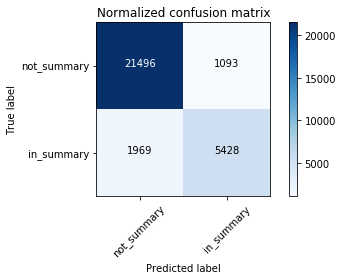

In [387]:
y_pred = mdl_rf.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False,
                      title='Normalized confusion matrix')

plt.show()

Normalized confusion matrix
[[0.95 0.05]
 [0.27 0.73]]


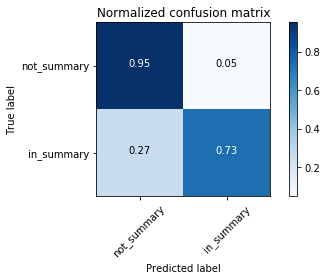

In [388]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Normalized confusion matrix
[[0.95 0.05]
 [0.32 0.68]]


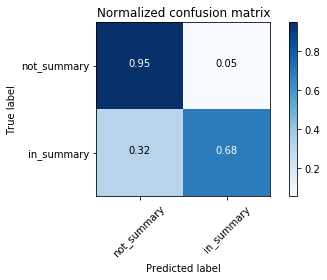

In [97]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [632]:
classifier = classifiers[0]
mdl = basic_classifier_train(classifier, X_train, X_test, y_train, y_test)

Accuracy: 0.9204463642908567 


In [645]:
report = calculate_metrics(mdl, X_test, y_test, as_csv=True, save=False)
report

,f1-score,precision,recall,support
0,0.956476,0.925667,0.989406,7363.0
1,0.537979,0.831897,0.397528,971.0
micro avg,0.920446,0.920446,0.920446,8334.0
macro avg,0.747228,0.878782,0.693467,8334.0
weighted avg,0.907717,0.914742,0.920446,8334.0


In [58]:
model_save_path = '../models/'

In [639]:
file_name = 'RandomForestClassifier_on_trainingdata_v1_GLOVEemb100_Education_nestimators1000_random_state0.pkl'

In [641]:
file_name = 'RandomForestClassifier_on_trainingdata_v1_GLOVEemb100_Education_nestimators1000_random_state0.pkl'
with open(model_save_path+file_name, 'wb') as picklefile:
    pickle.dump(mdl, picklefile)

In [643]:
mdl_2 = load_model(model_save_path+file_name)

In [650]:
report_name = (model_save_path + file_name).replace('.pkl', '_classification_report.csv')

In [652]:
report.to_csv(report_name)

In [653]:
from sklearn.metrics import confusion_matrix

In [667]:
y_test.values.ravel().shape

(8334,)

In [668]:
y_pred.shape

(8334,)

In [670]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

In [671]:
cnf_matrix

array([[7285,   78],
       [ 585,  386]])

In [675]:
class_names = target_names[:2]
class_names

['not_summary', 'in_summary']

Confusion matrix, without normalization
[[7285   78]
 [ 585  386]]
Normalized confusion matrix
[[0.99 0.01]
 [0.6  0.4 ]]


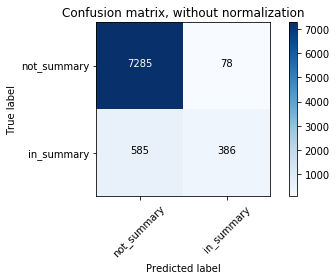

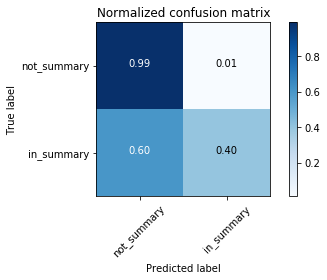

In [678]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [600]:
trial1 = sklearn.pipeline.Pipeline([('vectorizer', sklearn.feature_extraction.text.TfidfVectorizer()),
                                    ('classifier', sklearn.naive_bayes.MultinomialNB()), ])

In [277]:
X_words = np.array(full_sent)
X = data.drop(columns=['in_summary'])
y = data[['in_summary']]

In [220]:
X_train, X_test, y_train, y_test = split_data(X_words, y)
mdl = basic_classifier_train(trial1, X_train, X_test, y_train, y_test)
mdl

Accuracy: 0.9411764705882353 


Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=...      vocabulary=None)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [266]:
from sklearn.feature_extraction.text import HashingVectorizer
vector = vectorizer.transform(X_words)
# list of text documents
text = ["The quick brown fox jumped over the lazy dog."]
# create the transform
vectorizer = HashingVectorizer(n_features=20)
# encode document
vector = vectorizer.transform(text)
# summarize encoded vector
print(vector.shape)
print(vector.toarray())

(1, 20)
[[ 0.          0.          0.          0.          0.          0.33333333
   0.         -0.33333333  0.33333333  0.          0.          0.33333333
   0.          0.          0.         -0.33333333  0.          0.
  -0.66666667  0.        ]]


In [267]:
vectorizer = HashingVectorizer(n_features=20)
vector = vectorizer.transform(X_words)
vector.toarray()

## custom hashing 
[CUSTOM HASHING](https://towardsdatascience.com/hacking-scikit-learns-vectorizers-9ef26a7170af)

In [221]:
sklearn.metrics.accuracy_score(y_test, mdl.predict(X_test))   

0.9411764705882353

In [224]:
print(sklearn.metrics.precision_score(y_test, mdl.predict(X_test), pos_label=0) )
print(sklearn.metrics.precision_score(y_test, mdl.predict(X_test), pos_label=1) )

0.9411764705882353
0.0


In [225]:
print(sklearn.metrics.recall_score(y_test, mdl.predict(X_test), pos_label=0))
print(sklearn.metrics.recall_score(y_test, mdl.predict(X_test), pos_label=1))

1.0
0.0


In [242]:
print(sklearn.metrics.f1_score(y_test, mdl.predict(X_test), pos_label=1))

0.0


/Users/melissaferrari/anaconda3/envs/congress_py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [227]:
print(sklearn.metrics.f1_score(y_test, mdl.predict(X_test), pos_label=0))
print(sklearn.metrics.f1_score(y_test, mdl.predict(X_test), pos_label=1))

0.9696969696969697
0.0


In [250]:
print(sklearn.__version__)

0.20.2


In [252]:
classification_report = sklearn.metrics.classification_report(y_test, mdl.predict(X_test), output_dict=True)
print(sklearn.metrics.classification_report(y_test, mdl.predict(X_test), output_dict=False))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        16
           1       0.00      0.00      0.00         1

   micro avg       0.94      0.94      0.94        17
   macro avg       0.47      0.50      0.48        17
weighted avg       0.89      0.94      0.91        17



In [265]:
classification_report = pd.DataFrame(classification_report).transpose()

,f1-score,precision,recall,support
0,0.969697,0.941176,1.000000,16.0
1,0.000000,0.000000,0.000000,1.0
micro avg,0.941176,0.941176,0.941176,17.0
macro avg,0.484848,0.470588,0.500000,17.0
weighted avg,0.912656,0.885813,0.941176,17.0


In [232]:
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, mdl.predict(X_test))
confusion_matrix_normed = confusion_matrix.astype(float) / confusion_matrix.sum(axis=1)
print(confusion_matrix_normed)

[[1.     0.    ]
 [0.0625 0.    ]]


In [67]:
from nltk.corpus import stopwords

In [208]:
trial2 = sklearn.pipeline.Pipeline([('vectorizer', sklearn.feature_extraction.text.TfidfVectorizer(stop_words=stopwords.words('english'))),
                                    ('classifier', sklearn.naive_bayes.MultinomialNB()), ])
 
basic_classifier_train(trial2, X_train, X_test, y_train, y_test)

Accuracy: 0.9411764705882353 


Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=...      vocabulary=None)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [209]:
trial3 = sklearn.pipeline.Pipeline([('vectorizer', sklearn.feature_extraction.text.TfidfVectorizer(stop_words=stopwords.words('english'))),
                                    ('classifier', sklearn.naive_bayes.MultinomialNB(alpha=0.05)), ])

basic_classifier_train(trial3, X_train, X_test, y_train, y_test)

Accuracy: 0.7647058823529411 


Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=...     vocabulary=None)), ('classifier', MultinomialNB(alpha=0.05, class_prior=None, fit_prior=True))])

In [210]:
trial4 = sklearn.pipeline.Pipeline([('vectorizer', sklearn.feature_extraction.text.TfidfVectorizer(stop_words=stopwords.words('english'), min_df=5)),
                                    ('classifier', MultinomialNB(alpha=0.05)),])
 
basic_classifier_train(trial4, X_train, X_test, y_train, y_test)

Accuracy: 0.8823529411764706 


Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=...     vocabulary=None)), ('classifier', MultinomialNB(alpha=0.05, class_prior=None, fit_prior=True))])

In [213]:
import string
from nltk.stem import PorterStemmer
from nltk import word_tokenize
 
def stemming_tokenizer(text):
    stemmer = PorterStemmer()
    return [stemmer.stem(w) for w in word_tokenize(text)]
 
trial5 = sklearn.pipeline.Pipeline([('vectorizer', sklearn.feature_extraction.text.TfidfVectorizer(tokenizer=stemming_tokenizer,
                                                                                                   stop_words=stopwords.words('english') + list(string.punctuation))),
                                    ('classifier', sklearn.naive_bayes.MultinomialNB(alpha=0.05)),])
 
basic_classifier_train(trial5, X_train, X_test, y_train, y_test)

Accuracy: 0.7647058823529411 


/Users/melissaferrari/anaconda3/envs/congress_py36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", '``', 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=...rue, vocabulary=None)), ('classifier', MultinomialNB(alpha=0.05, class_prior=None, fit_prior=True))])

In [234]:
tfidfconverter = sklearn.feature_extraction.text.TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))  

In [241]:
tfidf.shape

(66, 44)

In [240]:
print(__doc__)

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

# #############################################################################
# Data IO and generation

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
X, y = X[y != 2], y[y != 2]
n_samples, n_features = X.shape

# Add noisy features
random_state = np.random.RandomState(0)
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
classifier = svm.SVC(kernel='linear', probability=True,
                     random_state=random_state)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

numpy.ndarray

### Show summary results.

In [712]:
inds = test_Y[test_Y['in_summary'] == 1].index.values

In [713]:
[full_sent[i] for i in inds]

['Not later than 1 year after the date of enactment of this Act, the Secretary of Education, acting through the Director of the Institute of Education Sciences, shall begin conducting a rigorous, longitudinal study of the impact and effectiveness of the student loan',
 'Of the amount authorized to be appropriated for maintaining the Department of Education’s Financial Awareness Counseling Tool, $2,000,000 shall be available to carry out this Act and the amendments made by this Act.']

# [FINE TUNE CLASSIFICATION](https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65)


In [686]:
def grid_search_wrapper(clf, refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train.values, y_train.values)

    # make the predictions
    y_pred = grid_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [687]:
mdl

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [689]:
clf = RandomForestClassifier(n_jobs=-1)

param_grid = {
    'min_samples_split': [3, 5, 10], 
    'n_estimators' : [100, 300],
    'max_depth': [3, 5, 15, 25],
    'max_features': [3, 5, 10, 20]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [ ]:
grid_search_clf = grid_search_wrapper(mdl, refit_score='precision_score')

# Adding features.

In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer

In [287]:
df_sub = df_tr[df_tr.bill_id.isin(unique_bills)]

In [283]:
unique_bills = feat.bill_id.unique()

In [495]:
(word_embeddings, embedding_size) = text_processing._extract_embeddings(path_to_embedding)

In [9]:
embedding_size

NameError: name 'embedding_size' is not defined

In [502]:
subject_table['subs_clean'] = [f.lower() for f in subject_table['subject'].values]
subject_table['subs_emb'] = [_calc_embedding(s, word_embeddings, embedding_size, True) for s in subject_table['subs_clean']]
subject_table['top_subs_clean'] = [f.lower() for f in subject_table['subjects_top_term'].values]
subject_table['top_subs_emb'] = [_calc_embedding(s, word_embeddings, embedding_size, True) for s in subject_table['top_subs_clean']]

In [80]:
from scipy.spatial import distance

In [ ]:
# cos = []
# for ix, row in subject_table.iterrows():
#     v1 = row['top_subs_emb']
#     v2 = row['subs_emb']
#     cos.append(distance.cosine(v1, v2))

In [81]:
subject_table = pd.read_csv('../data/subject_table_cosine_diff.csv')
del subject_table['Unnamed: 0']

In [515]:
len(cos)

268552

In [570]:
other = []
for ix, row in sub_health.iterrows():
    ot = str(row['official_title']).lower()
    st = str(row['short_title']).lower()
    if 'other' in ot:
        print(row['bill_id'], 'cosine_dif = {}'.format(row['cosine_dif']))
        print(ot)
        print()
        other.append(row['bill_id'])
    if 'other' in st:
        print(row['bill_id'], 'cosine_dif = {}'.format(row['cosine_dif']))
        prtin(st)
        other.append(row['bill_id'])
        print()

hr3926-114 cosine_dif = 0.4683228135108948
to amend the public health service act to provide for better understanding of the epidemic of gun violence, and for other purposes.

hr3926-114 cosine_dif = 0.6228677034378052
to amend the public health service act to provide for better understanding of the epidemic of gun violence, and for other purposes.

hr3926-114 cosine_dif = 0.33410245180130005
to amend the public health service act to provide for better understanding of the epidemic of gun violence, and for other purposes.

hr3926-114 cosine_dif = 0.0
to amend the public health service act to provide for better understanding of the epidemic of gun violence, and for other purposes.

hr3926-114 cosine_dif = 0.1529233455657959
to amend the public health service act to provide for better understanding of the epidemic of gun violence, and for other purposes.

hr3926-114 cosine_dif = 0.11845868825912476
to amend the public health service act to provide for better understanding of the epidemic

NameError: name 'prtin' is not defined

In [561]:
unique_subordered = sub_health.sort_values('cosine_dif', ascending=False)['subject'].unique()

In [ ]:
sub_health[~sub_health.subject.isin(['Micronesia', 'Oceania', 'Palau', 'Fishes', 'Self-employed', 'Guam', 'Syria'])].sort_values('cosine_dif', ascending=False)

In [ ]:
subject_table[subject_table.subjects_top_term=='Health'].sort_values('cosine_dif', ascending=False)

In [494]:
subject_table['subject'].unique()

array(['Armed forces and national security',
       'Health care costs and insurance', 'Mammals', ..., 'Turkmenistan',
       'Equatorial Guinea', 'Gabon'], dtype=object)

In [ ]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', stop_words=spacy_stopwords)
count_vect.fit(feats['clean_text'])

In [91]:
feat.head()

,loc_ix,tag,text,tag_rank,clean_text,abs_loc,norm_loc,bill_id
0,36,section,2. Deauthorization of appropriations to carry ...,2.0,NaN,0,0.000000,hr1005-113
1,40,section,3. Rescission of unobligated appropriations un...,2.0,NaN,4,1.000000,hr1005-113
2,33,section,2. Grants to States for scholarship programs S...,2.0,NaN,0,0.000000,hr1006-114
3,38,section,338N. Grants to States for scholarship programs,2.0,NaN,5,0.017065,hr1006-114
4,41,subsection,(a) In general The Secretary shall award grant...,3.0,a in general the secretary shall award grant...,8,0.027304,hr1006-114


In [387]:
feats_count = count_vect.transform(feats['clean_text'].values)

In [402]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000, 
                            tokenizer=stemming_tokenizer,stop_words=spacy_stopwords)
tfidf_vect.fit(feats['clean_text'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=5000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words={'will', 'could', 'by', 'thus', 'via', 'yourselves', 'ourselves', 'none', 'against', 'me', 'fifteen', 'latter', 'move', 'beside', 'whence', 'had', 'whereby', 'therefore', 'while', 'show', 'bottom', 'its', 'done', 'myself', 'call', 'almost', 'or', 'has', 'ca', 'himself', 'nine', 'on', 'bee...garding', 'even', 'last', 'still', 'take', 'thereafter', 'fifty', 'him', 'whether', 'your', 'below'},
        strip_accents=None, sublinear_tf=False, token_pattern='\\w{1,}',
        tokenizer=<function stemming_tokenizer at 0x1a634268c8>,
        use_idf=True, vocabulary=None)

In [ ]:
tfidfconverter = .TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))  

tfidf = tfidfconverter.fit_transform(full_sent).toarray()  

from sklearn.feature_extraction.text import HashingVectorizer
vector = vectorizer.transform(X_words)
# list of text documents
text = ["The quick brown fox jumped over the lazy dog."]
# create the transform
vectorizer = HashingVectorizer(n_features=20)
# encode document
vector = vectorizer.transform(text)
# summarize encoded vector
print(vector.shape)
print(vector.toarray())

In [92]:
from sklearn import decomposition

In [488]:
bill_id = unique_bills[50]
feats = feat[(feat['bill_id'] == bill_id)].copy()

bill = bills_info[bills_info['bill_id'] == bill_id].copy()
bill = _return_correct_bill_version(bill, as_dict=True)

official_title = bill['official_title'].lower()
short_title = bill['short_title'].lower()
subject = bill['subjects_top_term'].lower()
joint_title = official_title + short_title

bill_sub = list(subject_table[subject_table.bill_id == bill_id].subject.values)
bill_sub = [b.lower() for b in bill_sub]

feats['clean_text'] = feats['clean_text'].fillna("")

feats['title_word_count'] = feats['clean_text'].apply(lambda x: len([wrd for wrd in x.split() if wrd in joint_title]))

feats['char_count'] = feats['clean_text'].apply(len)
feats['word_count'] = feats['clean_text'].apply(lambda x: len(x.split()))
feats['word_density'] = feats['char_count'] / (feats['word_count']+1)

embds = df_sub[df_sub.bill_id == bill_id]
y = embds[['bill_id', 'in_summary']]

fea = feats[['tag_rank', 'abs_loc', 'norm_loc',  'title_word_count', 'char_count', 'word_count', 'word_density']]
fea = fea.reset_index(drop=True).merge(y.reset_index(drop=True), left_index=True, right_index=True)

X = fea.drop(columns=['in_summary'])

X = X.set_index('bill_id')
y = y.set_index('bill_id')

In [489]:
embds = df_sub[df_sub.bill_id == bill_id]
y = embds[['bill_id', 'in_summary']]

fea = feats[['tag_rank', 'abs_loc', 'norm_loc',  'title_word_count', 'char_count', 'word_count', 'word_density']]
fea = fea.reset_index(drop=True).merge(y.reset_index(drop=True), left_index=True, right_index=True)

X = fea.drop(columns=['in_summary'])

X = X.set_index('bill_id')
y = y.set_index('bill_id')

In [490]:
fea = feats[['tag_rank', 'abs_loc', 'norm_loc',  'title_word_count', 'char_count', 'word_count', 'word_density']]
fea = fea.reset_index(drop=True).merge(y.reset_index(drop=True), left_index=True, right_index=True)

X = fea.drop(columns=['in_summary'])

X = X.set_index('bill_id')
y = y.set_index('bill_id')

In [491]:
X = X.set_index('bill_id')
y = y.set_index('bill_id')

In [648]:
training_files = np.sort(os.listdir(PATH_TO_TRAINING))

In [93]:
X_ = pd.read_csv(PATH_TO_TRAINING +  'feats_allwordfeatures_nlp_Health20190210_x.csv')

In [94]:
y_ = pd.read_csv(PATH_TO_TRAINING +  'feats_allwordfeatures_nlp_Health20190210_y.csv')

In [100]:
df_tr.bill_id.nunique()

2663

In [98]:
X_.bill_id.nunique()

2579

In [101]:
X_.bill_id.unique()

array(['hr1005-113', 'hr1006-114', 'hr1011-115', ..., 's619-115',
       's620-114', 's621-114'], dtype=object)

In [219]:
feats = feat[['clean_text', 'bill_id']].copy()

In [223]:
df_omit = pd.DataFrame() ;X_omit = pd.DataFrame()
df_match = pd.DataFrame() ;X_match = pd.DataFrame()
df_empt = pd.DataFrame(); X_empt = pd.DataFrame()
y_match = pd.DataFrame(); feats_match = pd.DataFrame()

for bill_id in X_.bill_id.unique():
    df_temp = df[df['bill_id'] == bill_id]
    X_temp = X_[X_['bill_id'] == bill_id]
    y_temp = y_[y_['bill_id'] == bill_id]
    feats_temp = feats[feats['bill_id'] == bill_id]

    if X_temp.word_count.sum() == 0:
        df_empt = df_empt.append(df_temp)
        X_empt = X_empt.append(X_temp)
    elif len(df_temp.loc_ix.values) == len(X_temp.index.values):
        #if all(df_temp.loc_ix.values == X_temp.index.values):
        df_match = df_match.append(df_temp)
        X_match = X_match.append(X_temp)
        y_match = y_match.append(y_temp)
        feats_match = feats_match.append(feats_temp)
    else:
        print(bill_id)
        print(df_temp.loc_ix.values)
        print(X_temp.index.values)
        print()

In [470]:
y_test_copy = y_test.copy()

In [471]:
y_test['predictions'] = y_pred

/Users/melissaferrari/anaconda3/envs/congress_py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [228]:
X_match.to_csv(PATH_TO_TRAINING +  'feats_allwordfeatures_nlp_Health20190210_xclean.csv')
y_match.to_csv(PATH_TO_TRAINING +  'feats_allwordfeatures_nlp_Health20190210_yclean.csv')
df_match.to_csv(PATH_TO_TRAINING +  'feats_allwordfeatures_nlp_Health20190210_embeddings.csv')
feats_match.to_csv(PATH_TO_TRAINING +  'feats_allwordfeatures_nlp_Health20190210_featsmatch.csv')

In [239]:
feats_match = pd.read_csv(PATH_TO_TRAINING +  'feats_allwordfeatures_nlp_Health20190210_featsmatch.csv', )

In [ ]:
X_ = pd.read_csv(PATH_TO_TRAINING +  'feats_allwordfeatures_nlp_Health20190210_x.csv')
y_ = pd.read_csv(PATH_TO_TRAINING +  'feats_allwordfeatures_nlp_Health20190210_y.csv')

In [182]:
df_training = df_match.drop(columns = ['loc_ix', 'in_summary', 'bill_id']) 

In [184]:
X_training = X_match.drop(columns=['bill_id'])

In [186]:
y_training = y_match.drop(columns=['bill_id'])

In [192]:
X_training.head()

,tag_rank,abs_loc,norm_loc,title_word_count,char_count,word_count,word_density
2,2.0,0,0.000000,0,0,0,0.000000
3,2.0,5,0.017065,0,0,0,0.000000
4,3.0,8,0.027304,14,425,59,7.083333
5,3.0,12,0.040956,9,219,35,6.083333
6,3.0,16,0.054608,6,155,24,6.200000


In [191]:
df_training.head()

,embed_000,embed_001,embed_002,embed_003,embed_004,embed_005,embed_006,embed_007,embed_008,embed_009,...,embed_090,embed_091,embed_092,embed_093,embed_094,embed_095,embed_096,embed_097,embed_098,embed_099
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,-0.028989,0.103344,0.079738,0.020541,0.075668,0.055258,-0.179154,0.197794,-0.241951,0.027738,...,0.065888,-0.193982,-0.094773,0.054473,-0.382659,0.121484,-0.019625,-0.299626,0.437953,-0.045252
5,-0.164549,0.129880,0.353852,-0.148361,0.157357,0.104620,-0.205400,0.396299,-0.097947,0.090823,...,-0.137195,-0.071488,-0.201279,-0.010435,-0.270524,-0.003561,-0.028155,-0.326149,0.434794,-0.042334
6,0.024833,0.318236,0.041083,-0.161317,0.144998,0.265488,0.009614,0.480965,-0.301470,0.159222,...,-0.226657,-0.125049,-0.086857,-0.033678,-0.269597,0.084446,-0.093459,-0.163654,0.457416,-0.031673


In [ ]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', stop_words=spacy_stopwords)
count_vect.fit(feats_match['clean_text']);

In [243]:
pd.set_index?

Object `pd.set_index` not found.


In [244]:
feats_match = feats_match.set_index('Unnamed: 0')

In [260]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000, 
                            top_words=spacy_stopwords, tokenizer=stemming_tokenizer,s)
tfidf_vect.fit(feats_match['clean_text'] )

/Users/melissaferrari/anaconda3/envs/congress_py36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'doe', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'quit', 'realli', 'regard', 'seriou', 'sever', 'sinc', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'use', 'variou', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'where

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=5000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words={'could', 'once', 'amount', 'yet', 'nevertheless', 'through', 'above', 'again', 'other', 'per', 'twelve', 'eight', 'else', 'call', 'always', 'anyhow', 'various', 'thru', 'whom', 'hence', 'done', 'thence', 'somehow', 'therefore', 'no', 'were', 'those', 'about', 'sometime', 'last', 'seeming...ne', 'among', 'these', 'after', 'few', 'except', 'namely', 'three', 'almost', 'get', 'by', 'really'},
        strip_accents=None, sublinear_tf=False, token_pattern='\\w{1,}',
        tokenizer=<function stemming_tokenizer at 0x1a6ee0ee18>,
        use_idf=True, vocabulary=None)

In [265]:
tfidfconverter = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))  
#tfidf = tfidfconverter.fit_transform(full_sent).toarray()  

#trans = tfidf_vect.transform(feats_match['clean_text'] )

In [266]:
tfidf = tfidfconverter.fit(feats_match['clean_text'] )


In [267]:
tfidft = tfidfconverter.fit_transform(feats_match['clean_text']) #.toarray()

In [270]:
tfidft

<149926x1500 sparse matrix of type '<class 'numpy.float64'>'
	with 1494168 stored elements in Compressed Sparse Row format>

In [248]:
feats_match.head()

,clean_text,bill_id
2,NaN,hr1006-114
3,NaN,hr1006-114
4,a in general the secretary shall award grant...,hr1006-114
5,b eligible states to be eligible to receive ...,hr1006-114
6,c eligible participants to be eligible to pa...,hr1006-114


In [259]:
feats_match['clean_text'] = feats_match['clean_text'].fillna('')